# Synthetic Control Method (SCM)

## What is a synthetic control method?

Synthetic control methods were originally proposed in Abadie and Gardeazabal (2003) with the aim of estimating the effects of aggregate interventions on some aggregate outcome of interest [1]. Here, aggregate interventions are the interventions that are implemented at an aggregate level and affect a small number of large units (such as cities, regions, or countries). It is based on the idea that when the observation is made at an aggregate entity level, a combination of unaffected units may provide a more appropriate comparison than any single unaffected unit. To put it simply, it compares the treatment group to a weighted combination of control groups. 

## SCM has two major advantages over traditional quasi-experimental techniques:

1) It can account for the effect of confounders changing over time, whereas DID’s parallel trend assumption implies that, without the intervention, outcomes for the treated and control groups would have followed parallel trajectories over time [1].

2) This methodology formalizes the selection of the comparison units using a data-driven procedure [2].

To make matters a little bit more formal, suppose that we have $J+1$ units. Without loss of generality, assume that unit 1 is the unit that gets affected by an intervention. Units $j=2,...,J+1$ are a collection of untreated units that we will refer to as the "donor pool". Also assume that the data we have span T time periods, with $T_0$ periods before the intervention. For each unit j and each time t, we observe the outcome $Y_{jt}$. For each unit j and period t, define $Y^N_{jt}$ as the potential outcome without intervention and $Y^I_{jt}$, the potential outcome with intervention. Then, the effect for the treated unit $j=1$ at time t, for $t>T_0$ is defined as 

$
\tau_{1t} = Y^I_{1t} - Y^N_{1t}
$

Since unit $j=1$ is the treated one, $Y^I_{1t}$ is factual but $Y^N_{1t}$ is not. The challenge then becomes how do we estimate $Y^N_{1t}$. Notice how the treatment effect is defined for each period, which means it can change in time. It doesn't need to be instantaneous. It can accumulate or dissipate. To put it in a picture, the problem of estimating the treatment effect boils down to the problem of **estimating what would have happened to the outcome of unit $j=1$ if it had not been treated**.

![img](data/img/synth_img.png)

To estimate $Y^N_{1t}$, we remember that a combination of units in the donor pool may approximate the characteristics of the treated unit much better than any untreated unit alone. Thus, a synthetic control is defined as a weighted average of the units in the control pool. Given the weights $\pmb{W}=(w_2, ..., w_{J+1})$, the synthetic control estimate of $Y^N_{1t}$ is

$
\hat{Y}^N_{1t} = \sum^{J+1}_{j=2} w_j Y_{jt}
$


we will use weights $\pmb{W}=(w_2, ..., w_{J+1})$ that minimises

$
||\pmb{X}_1 - \pmb{X}_0 \pmb{W}|| = \bigg(\sum^k_{h=1}v_h \bigg(X_{h1} - \sum^{J+1}_{j=2} w_j X_{hj} \bigg)^2 \bigg)^{\frac{1}{2}}
$

subject to the restriction that $w_2, ..., w_{J+1}$ are `positive and sum to one`. 

Notice that $v_h$ reflect the importance of each variable when minimising the difference between the treated and the synthetic control. Different $v$ s would give different optimal weights. One way to choose $V$ is to make it so that each variable has mean zero and unit variance. A more complex way is to choose $V$ in such a way that variables that help to predict $Y$ better get higher importance. Since we want to keep the code simple, we will simply give the same importance for each variable.

## Implementation Example:

To see it in action, consider the problem of estimating the effect of cigarette taxation on its consumption. To give a bit of context, this is a question that had been debated for a long time in economics. One side of the argument says that taxes will increase the cost of cigars, which will lower its demand. The other side argues that since cigarettes cause addiction, change in their price won't change their demand by much. In economic terms, we would say that the demand for cigarettes is inelastic on price, and an increase in taxation is just a way to increase government income at the cost of smokers. To settle things, we will look at some US data regarding the matter.

In 1988, California passed a famous Tobacco Tax and Health Protection Act, which became known as [Proposition 99](https://en.wikipedia.org/wiki/1988_California_Proposition_99). "Its primary effect is to impose a 25-cent per pack state excise tax on the sale of tobacco cigarettes within California, with approximately equivalent excise taxes similarly imposed on the retail sale of other commercial tobacco products, such as cigars and chewing tobacco. Additional restrictions placed on the sale of tobacco include a ban on cigarette vending machines in public areas accessible by juveniles, and a ban on the individual sale of single cigarettes. Revenue generated by the act was earmarked for various environmental and health care programs, and anti-tobacco advertisements." 

To evaluate its effect, we can gather data on cigarette sales from multiple states and across a number of years. In our case, we got data from the year 1970 to 2000 from 39 states. Other states had similar Tobacco control programs and were dropped from the analysis. Here is what our data looks like.

## Prepare Notebook

In [1]:
import pandas as pd
import numpy as np
# import seaborn as sns
import matplotlib.pyplot as plt
from toolz import partial
from scipy.optimize import fmin_slsqp

## Read Data

In [2]:
df_pre = pd.read_csv("data/smoking_data.csv")
df_pre.head()

,state,year,cigsale,lnincome,beer,age15to24,retprice
0,Alabama,1970,89.800003,NaN,NaN,0.178862,39.599998
1,Alabama,1971,95.400002,NaN,NaN,0.179928,42.700001
2,Alabama,1972,101.099998,9.498476,NaN,0.180994,42.299999
3,Alabama,1973,102.900002,9.550107,NaN,0.182060,42.099998
4,Alabama,1974,108.199997,9.537163,NaN,0.183126,43.099998


In [3]:
df = pd.read_csv("data/smoking_data.csv").drop(columns=["lnincome","beer", "age15to24"])
df.head()

,state,year,cigsale,retprice
0,Alabama,1970,89.800003,39.599998
1,Alabama,1971,95.400002,42.700001
2,Alabama,1972,101.099998,42.299999
3,Alabama,1973,102.900002,42.099998
4,Alabama,1974,108.199997,43.099998


As we see in the above image our data has three columns: State, year and cigsale which is our outcome variable of interest aka “annual per capita cigarette sale”. Since we will be using lagged data as covariates for our exercise; we need to transform it into panel data i.e. each row will represent the year and each column will represent the state.

In [4]:
# converting data to panel data
df=df.pivot(index= 'year', columns = 'state', values = "cigsale").reset_index()
df.head()

state,year,Alabama,Arkansas,California,Colorado,Connecticut,Delaware,Georgia,Idaho,Illinois,...,South Carolina,South Dakota,Tennessee,Texas,Utah,Vermont,Virginia,West Virginia,Wisconsin,Wyoming
0,1970,89.800003,100.300003,123.000000,124.800003,120.000000,155.000000,109.900002,102.400002,124.800003,...,103.599998,92.699997,99.800003,106.400002,65.500000,122.599998,124.300003,114.500000,106.400002,132.199997
1,1971,95.400002,104.099998,121.000000,125.500000,117.599998,161.100006,115.699997,108.500000,125.599998,...,115.000000,96.699997,106.300003,108.900002,67.699997,124.400002,128.399994,111.500000,105.400002,131.699997
2,1972,101.099998,103.900002,123.500000,134.300003,110.800003,156.300003,117.000000,126.099998,126.599998,...,118.699997,103.000000,111.500000,108.599998,71.300003,138.000000,137.000000,117.500000,108.800003,140.000000
3,1973,102.900002,108.000000,124.400002,137.899994,109.300003,154.699997,119.800003,121.800003,124.400002,...,125.500000,103.500000,109.699997,110.400002,72.699997,146.800003,143.100006,116.599998,109.500000,141.199997
4,1974,108.199997,109.699997,126.699997,132.800003,112.400002,151.300003,123.699997,125.599998,131.899994,...,129.699997,108.400002,114.800003,114.699997,75.599998,151.800003,149.600006,119.900002,111.800003,145.800003


## EDA

Next is selecting the treatment state, which in our case is California and treatment year is 1989, the first year when Proposition 99 was introduced in California. Before moving onto constructing a synthetic California for our study let us compare the cig sale in California with the mean of cig sale in the rest of the control states in this study.

In [5]:
# selecting the treatment state and year
treatment_year = 1988
treated_state = 'California'

#calculating mean cig sale in control sates throughout the time period of study
states = [x for x in df.columns if x!='year']

# df['Other States'] = df[[x for x in states if x!=treated_state and x!= 'year']].mean(axis=1)

df['Other States'] = df[[x for x in states if x!=treated_state]].mean(axis=1)
df.head()

state,year,Alabama,Arkansas,California,Colorado,Connecticut,Delaware,Georgia,Idaho,Illinois,...,South Dakota,Tennessee,Texas,Utah,Vermont,Virginia,West Virginia,Wisconsin,Wyoming,Other States
0,1970,89.800003,100.300003,123.000000,124.800003,120.000000,155.000000,109.900002,102.400002,124.800003,...,92.699997,99.800003,106.400002,65.500000,122.599998,124.300003,114.500000,106.400002,132.199997,120.084212
1,1971,95.400002,104.099998,121.000000,125.500000,117.599998,161.100006,115.699997,108.500000,125.599998,...,96.699997,106.300003,108.900002,67.699997,124.400002,128.399994,111.500000,105.400002,131.699997,123.863158
2,1972,101.099998,103.900002,123.500000,134.300003,110.800003,156.300003,117.000000,126.099998,126.599998,...,103.000000,111.500000,108.599998,71.300003,138.000000,137.000000,117.500000,108.800003,140.000000,129.178948
3,1973,102.900002,108.000000,124.400002,137.899994,109.300003,154.699997,119.800003,121.800003,124.400002,...,103.500000,109.699997,110.400002,72.699997,146.800003,143.100006,116.599998,109.500000,141.199997,131.539473
4,1974,108.199997,109.699997,126.699997,132.800003,112.400002,151.300003,123.699997,125.599998,131.899994,...,108.400002,114.800003,114.699997,75.599998,151.800003,149.600006,119.900002,111.800003,145.800003,134.668421


In [6]:
def plot_sales(df,treated_state,col_2,treatment_year, **kwargs):
    plt.plot(df['year'],df[treated_state], label=treated_state, **kwargs)
    plt.plot(df['year'],df[col_2], label = col_2)
    plt.axvline(x=treatment_year, ls=":", color='C2', label='Proposition 99', zorder=1)
    plt.legend()
    # plt.title("Average cig sale per year")
    plt.show()
 

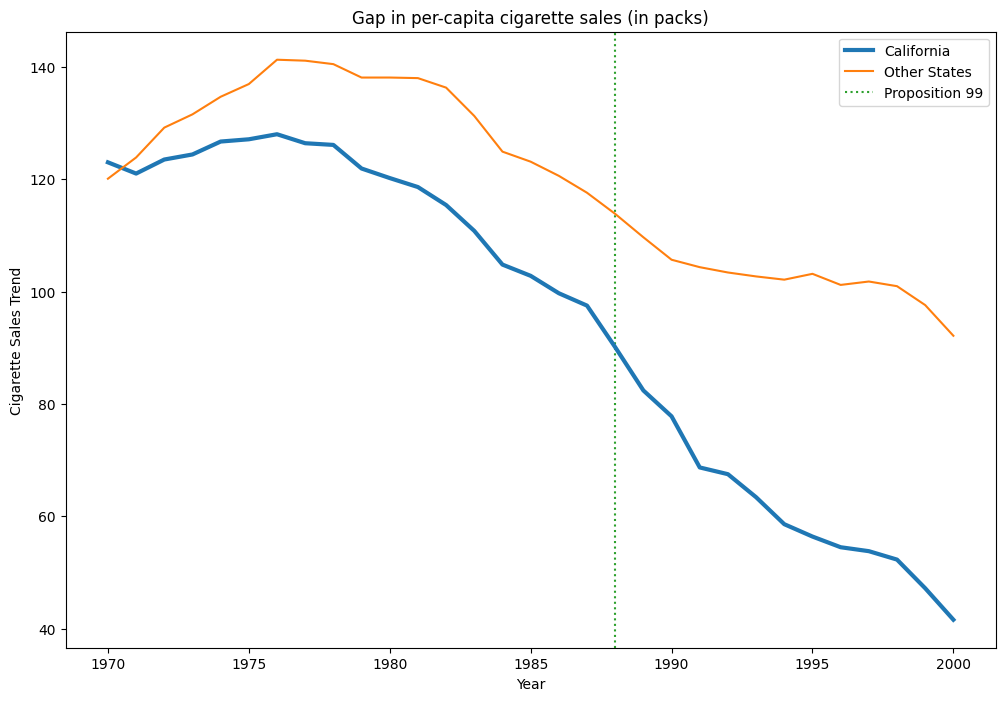

In [7]:
plt.figure(figsize = (12, 8))
plt.xlabel('Year')
plt.ylabel("Cigarette Sales Trend")
plt.title("Gap in per-capita cigarette sales (in packs)")

plot_sales(df,treated_state,'Other States',treatment_year, lw= 3)

Looking at the above figure, it does seem like cig sales in California post 1989 declined more rapidly than the rest of control states. Next step is constructing synthetic California. We will first define our regression function with the below constraints:

## Data Processing

## Model

In [8]:
class SyntheticControl():
    
    # Loss function
    def loss(self, W, X, y) -> float:
        return np.sqrt(np.mean((y - X.dot(W))**2))

    # Fit model
    def fit(self, X, y):
        w_start = [1/X.shape[1]]*X.shape[1]
        self.coef_ = fmin_slsqp(partial(self.loss, X=X, y=y),
                         np.array(w_start),
                         f_eqcons=lambda x: np.sum(x) - 1,
                         bounds=[(0.0, 1.0)]*len(w_start),
                         disp=False)
        
        self.mse = self.loss(W=self.coef_, X=X, y=y)
        
        return self
    
    # Predict 
    def predict(self, X):
        return X.dot(self.coef_)

## The function to predict synthetic California:

In [9]:
def predict_synthetic_data(df, model, state, year):
    other_states = [x for x in states if x not in [state]]
    y = df[df['year']<=year][state]
    X = df[df['year']<=year][other_states]
    state_col = 'Synthetic '+ state
    df[state_col] = model.fit(X, y).predict(df[other_states])
    return model

Let us now construct our synthetic California and look at the weights of the control states:

In [10]:
df_states = pd.DataFrame()
df_states['state'] = ['Alabama', 'Arkansas', 'Colorado', 'Connecticut','Delaware', 'Georgia', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Minnesota', 'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire', 'New Mexico', 'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia', 'West Virginia', 'Wisconsin', 'Wyoming']

df_states['coef_synth'] = predict_synthetic_data(df, SyntheticControl(), treated_state, treatment_year).coef_
df_states.head()

,state,coef_synth
0,Alabama,5.427409e-14
1,Arkansas,4.061020e-14
2,Colorado,1.482046e-02
3,Connecticut,1.091034e-01
4,Delaware,0.000000e+00


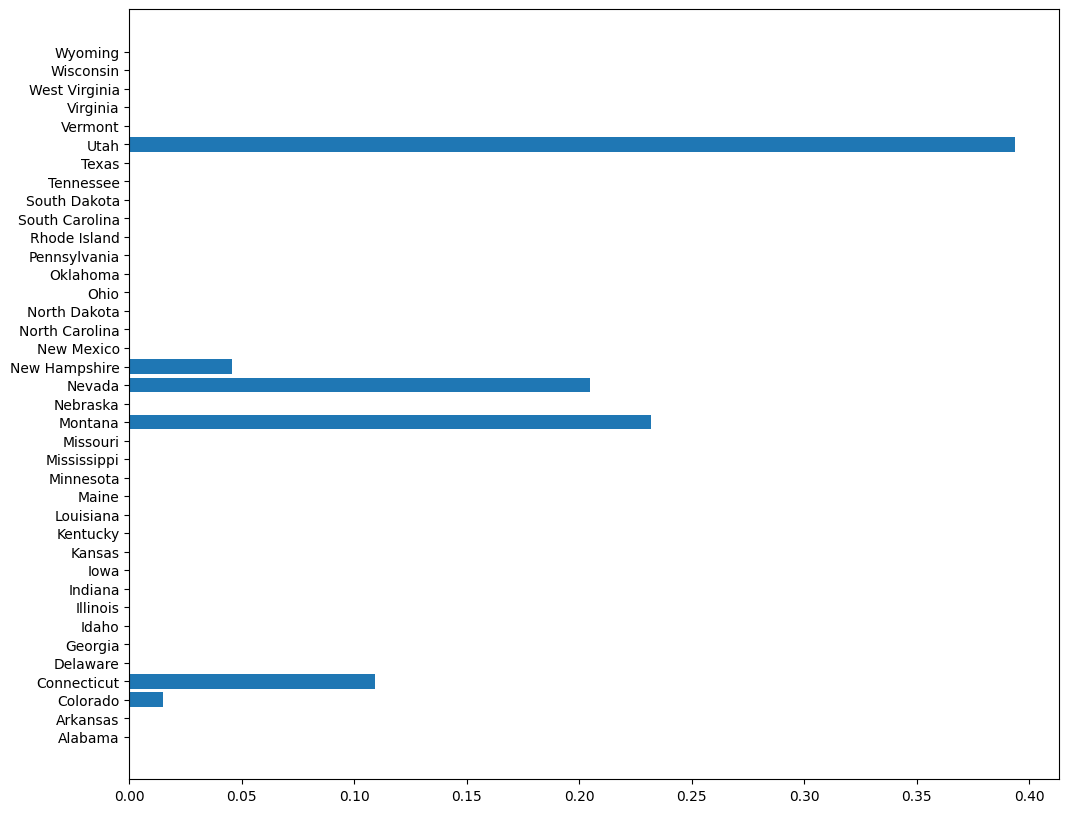

In [11]:
plt.figure(figsize=(12, 10))
plt.barh(df_states['state'], df_states['coef_synth']);
# sns.barplot(data=df_states, x='coef_synth', y='state');

In [ ]:
df.head()

The coefficients/weights obtained from this exercise are almost similar to the ones mentioned in [4]. The slight variances are due to the difference in covariates that were used in [4] and in this example. It is now time to compare the synthetic California with observed California.

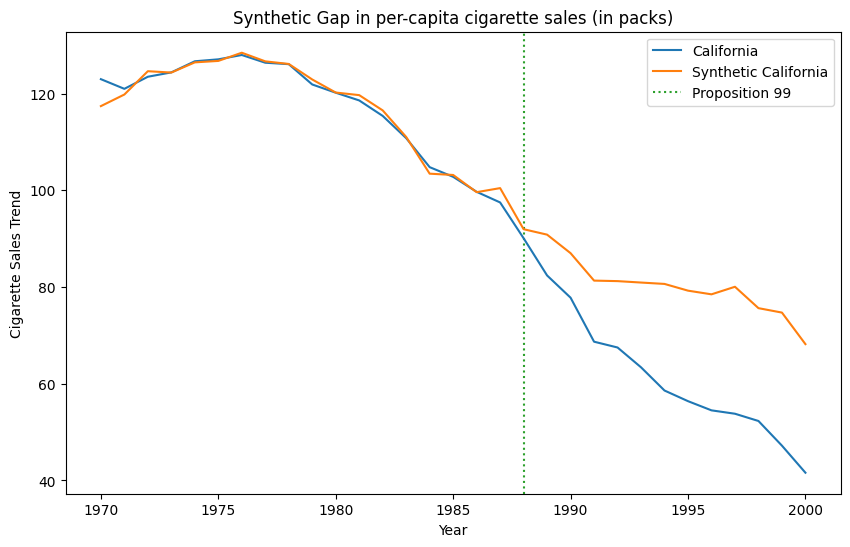

In [12]:
plt.figure(figsize=(10,6))
plt.xlabel('Year')
plt.ylabel("Cigarette Sales Trend")
plt.title("Synthetic Gap in per-capita cigarette sales (in packs)")

plot_sales(df, treated_state, f'Synthetic {treated_state}', treatment_year)

Looking at the above plot, it looks like the effect of Proposition 99 on cig. sale is negative, however let’s visualize the difference between observed and synthetic California:

In [13]:
def plot_difference(df, city, year, vline=True, hline=True, **kwargs):
    plt.plot(df['year'], df[city] - df[f'Synthetic {city}'], **kwargs)
    if vline: 
        plt.axvline(x=year, ls=":", color='C2', label='Proposition 99', lw=3, zorder=100)
        plt.legend()
    if hline: 
        plt.hlines(y=0, xmin=1970, xmax=2000, lw=2, color='k', zorder=1)
    plt.xlabel('Year')
    plt.ylabel("Cigarette Sales Trend")
    plt.title("Synthetic Gap in per-capita cigarette sales (in packs)")
    # plt.show();



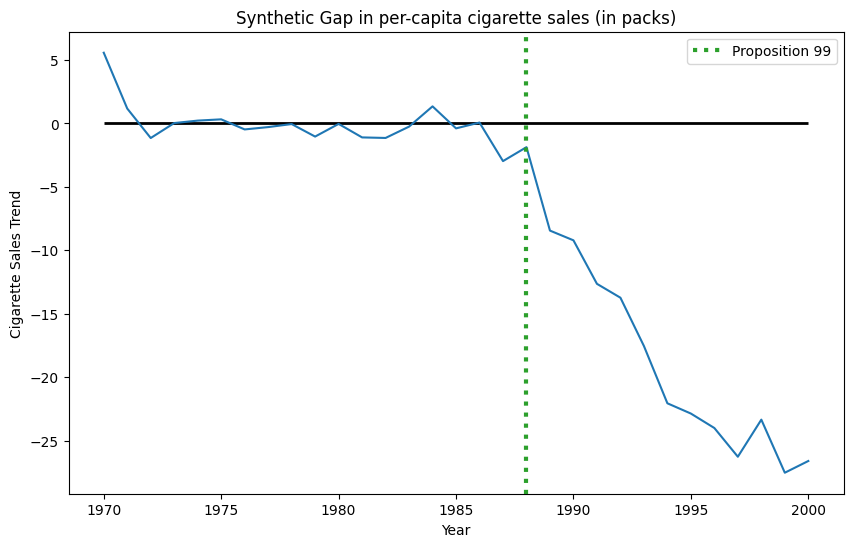

In [14]:
plt.figure(figsize=(10,6))

plot_difference(df, treated_state, treatment_year)

The difference plot is able to bring out the negative difference between synthetic and observed California especially after 1988 which is our treatment year. Although we now we could observe the negative effect of Propsition 99 on cig sales in California but the important question which remains is how do we determine that this effect is statistically significant. This bring us to the last section of the article which is Inference.

## Predictions

## Making Inference

Now that we have constructed our synthetic California and identified the difference between synthetic and observed California, how do we estimate the statistical significance of our study? To simply put it, how do we determine that the impact observed for California is not a chance occurrence. We will use the Permutation Test also described as a placebo study in [4]. We will apply synthetic control methods to the states that did not implement Proposition 99 during the time period of our study. The idea is that by applying synthetic control to other states if we do not observe an impact as big as California, then the impact of Proposition 99 on California is significant.

1. Creating synthetic control for all the states and plotting the difference between synthetic and observed states:

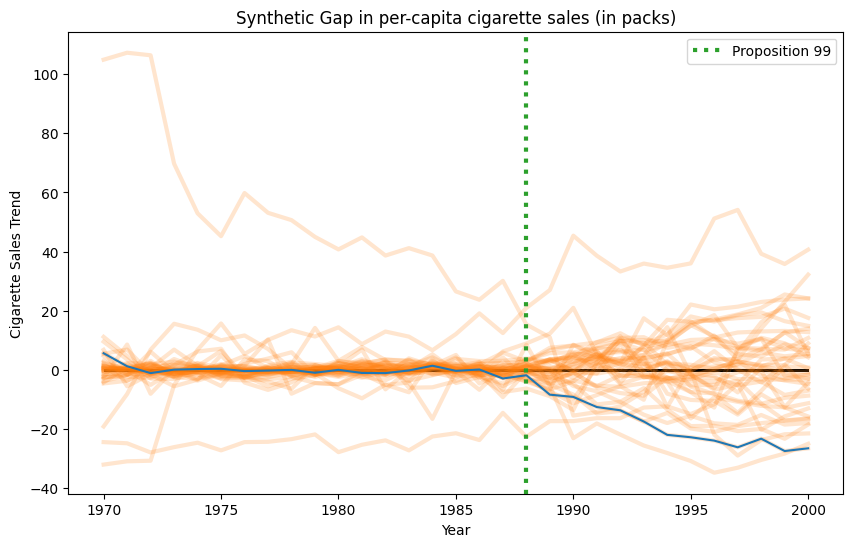

In [19]:
plt.figure(figsize=(10,6))
for state in states:
    mse = predict_synthetic_data(df, SyntheticControl(), state, treatment_year).mse
    plot_difference(df, state, treatment_year, vline=False, alpha=0.2, color='C1', lw=3)

plot_difference(df, treated_state, treatment_year)

Two aspects of this figure jump to the eyes.

- We can see that the variance after the intervention is higher than the variance before the intervention. This is expected, since the synthetic control is designed to minimize the difference in the pre-intervention period. 

- There are some units we can't fit very well even in the pre-intervention period. This is also to be expected. For example, if some states have very high cigarette consumption, no convex combination of the other states will ever match them. 

Since those units are so poorly fit, it is a good idea to remove them from the analysis. One way to do it objectively is to set a threshold for pre-intervention error 

$
MSE = \frac{1}{N}\sum\bigg(Y_t - \hat{Y}^{Synth}_t\bigg)^2
$

and remove those units with high error. If we proceed like this and plot the same figure, this is what we get.


We could observe in the above graph that for some states we did not get a very good fit. In [4], it is suggested that we remove states with MSE > 2*MSE of treatment state.

2. Let’s remove the states with MSE > 2*MSE of treatment state and look at the estimated difference between synthetic control and states.

In [16]:
mse_treated = predict_synthetic_data(df, SyntheticControl(), treated_state, treatment_year).mse
mse_treated

1.6564002229290016

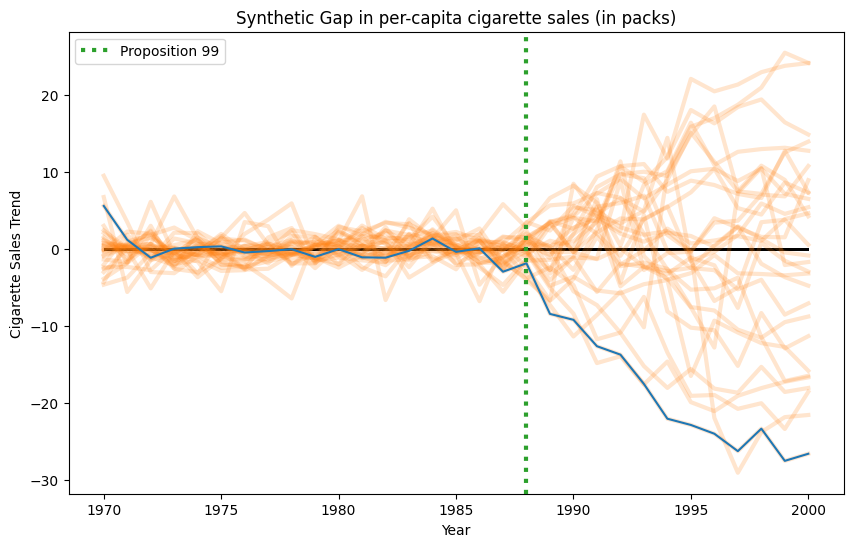

In [20]:
# Other mse
plt.figure(figsize=(10,6))
for state in states:
    mse = predict_synthetic_data(df, SyntheticControl(), state, treatment_year).mse
    if mse < 2 * mse_treated:
        plot_difference(df, state, treatment_year, vline=False, alpha=0.2, color='C1', lw=3)
plot_difference(df, treated_state, treatment_year)

After excluding the extreme states it looks like the effect of Proposition 99 on California is rare. In [4], the ratio between MSE Pre and MSE Post was used for the permutation test.

3. Let us calculate that ratio and estimate the p-value for the test:

In [21]:
#computing p-values for states in higher ratio

lambdas = {}
for state in states:
    mse_pre = predict_synthetic_data(df, SyntheticControl(), state, treatment_year).mse
    mse_tot = np.mean((df[f'Synthetic {state}'] - df[state])**2)
    lambdas[state] = (mse_tot - mse_pre) / mse_pre
    
print(f"p-value: {np.mean(np.fromiter(lambdas.values(), dtype='float') > lambdas[treated_state]):.4}")


p-value: 0.02564


The p-value for our test is 0.0256 i.e. if one were to assign the intervention at random in this data, the probability of obtaining a MSE post/ MSE pre as large as California is ~0.026.

## References:

[1] Abadie, A. (2021). Using synthetic controls: Feasibility, data requirements, and methodological aspects. Journal of Economic Literature, 59(2), 391–425.

[2] Abadie, A., Diamond, A., & Hainmueller, J. (2015). Comparative politics and the synthetic control method. American Journal of Political Science, 59(2), 495–510.

[3] Abadie, A., & Gardeazabal, J. (2003). The economic costs of conflict: A case study of the Basque Country. American economic review, 93(1), 113–132.

[4] Abadie, A., Diamond, A., & Hainmueller, J. (2010). Synthetic control methods for comparative case studies: Estimating the effect of California’s tobacco control program. Journal of the American statistical Association, 105(490), 493–505.

[5] Doudchenko, N., & Imbens, G. W. (2016). Balancing, regression, difference-in-differences and synthetic control methods: A synthesis (No. w22791). National Bureau of Economic Research.

[6] Data source — Per-capita cigarette consumption (in packs). Source: Orzechowski and Walker (2005), Access & Use Information — Public